# 1. LSTM Data Preprocessing

This notebook contains the preprocessing steps to prepare the complete California fentanyl OD death dataset for input to the LSTM model.  

Lucy Herr
<br>3/10/24
<br>UCB MIDS Capstone Spring 2024

## Import libraries and dataset

In [697]:
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# time series split 
from sklearn.model_selection import TimeSeriesSplit
# robust scaling for skewed features
from sklearn.preprocessing import RobustScaler
# OHE for county names, 
import category_encoders as ce
# custom functions for project
import lh_fx

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

In [698]:
# import full dataset as of 3/10/24
#df = pd.read_csv("raw_data/ssImp_ALL_Merged_Dataset_3_10_24.csv") # OLDER VERSION NULLS, NO AGE PERCENTAGE COLUMNS
df_new = pd.read_csv("raw_data/full_with_age_pcts_LSTM.csv")

## Key data checks

### 1. Dimensions

In [699]:
df.shape

(5568, 117)

In [700]:
df_new.shape

(5568, 139)

### 2. Column data types

In [701]:
# display all features and dtypes
for c, d in zip(df.columns, df.dtypes):
    print(f"{c}: {d}")

county_fips: int64
county_name: object
state: object
month_date: object
period: datetime64[ns]
year: int64
month: int64
quarter: int64
Overdose_Rate_X100K: float64
county_all_drugs_death_count: int64
county_all_drugs_monthly_rate: float64
county_population: int64
lagged_neighbor_all_drugs_deaths: float64
lagged_neighbor_all_drugs_monthly_rate: float64
county_all_drugs_death_count_2mo_rolling: float64
POPESTIMATE: int64
POPEST_MALE: int64
POPEST_FEM: int64
UNDER5_TOT: int64
UNDER5_MALE: int64
UNDER5_FEM: int64
AGE513_TOT: int64
AGE513_MALE: int64
AGE513_FEM: int64
AGE1417_TOT: int64
AGE1417_MALE: int64
AGE1417_FEM: int64
AGE1824_TOT: int64
AGE1824_MALE: int64
AGE1824_FEM: int64
AGE16PLUS_TOT: int64
AGE16PLUS_MALE: int64
AGE16PLUS_FEM: int64
AGE18PLUS_TOT: int64
AGE18PLUS_MALE: int64
AGE18PLUS_FEM: int64
AGE1544_TOT: int64
AGE1544_MALE: int64
AGE1544_FEM: int64
AGE2544_TOT: int64
AGE2544_MALE: int64
AGE2544_FEM: int64
AGE4564_TOT: int64
AGE4564_MALE: int64
AGE4564_FEM: int64
AGE65PLUS_TO

In [702]:
# display all features and dtypes
for c, d in zip(df_new.columns, df_new.dtypes):
    print(f"{c}: {d}")

county_fips: int64
county_name: object
state: object
month_date: object
period: int64
year: int64
month: int64
quarter: int64
Overdose_Rate_X100K: float64
county_all_drugs_death_count: int64
county_all_drugs_monthly_rate: float64
county_fentanyl_death_count: float64
county_fentanyl_monthly_rate: float64
county_pct_fentanyl: float64
county_population: int64
lagged_neighbor_all_drugs_deaths: float64
lagged_neighbor_fentanyl_deaths: float64
lagged_neighbor_all_drugs_monthly_rate: float64
lagged_neighbor_fentanyl_monthly_rate: float64
lagged_neighbor_pct_fentanyl: float64
county_all_drugs_death_count_2mo_rolling: float64
county_all_drugs_death_high_2mo: float64
county_all_drugs_death_low_2mo: float64
county_all_drugs_death_avg_2mo: float64
county_all_drugs_death_high_3mo: float64
county_all_drugs_death_low_3mo: float64
county_all_drugs_death_avg_3mo: float64
lagged_neighbor_all_drugs_deaths_2mo_rolling: float64
lagged_neighbor_all_drugs_high_2mo: float64
lagged_neighbor_all_drugs_low_2mo: 

#### Cast 'period' column to datetime

In [703]:
df['period'] = pd.to_datetime(df['period'],format = '%Y%m')
df.period.unique()

array(['2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-05-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2017-12-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-01

In [704]:
df_new['period'] = pd.to_datetime(df_new['period'],format = '%Y%m')
df_new.period.unique()

array(['2016-01-01T00:00:00.000000000', '2016-02-01T00:00:00.000000000',
       '2016-03-01T00:00:00.000000000', '2016-04-01T00:00:00.000000000',
       '2016-05-01T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-07-01T00:00:00.000000000', '2016-08-01T00:00:00.000000000',
       '2016-09-01T00:00:00.000000000', '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000',
       '2017-01-01T00:00:00.000000000', '2017-02-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2017-05-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2017-08-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2017-10-01T00:00:00.000000000',
       '2017-11-01T00:00:00.000000000', '2017-12-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-04-01

#### Drop 'fips' columns (duplicate with 'county_fips')

In [705]:
# df.drop('fips', axis=1, inplace=True)
# df.shape

### 3. Confirm data contains only counties in California

In [706]:
df.state.unique()

array(['CA'], dtype=object)

### 4. Address remaining missing values 

In [707]:
null_df = lh_fx.make_null_df(df)
null_df

,feature_name,percent_null
0,county_all_drugs_death_count_2mo_rolling,1.041667
1,lagged_neighbor_all_drugs_monthly_rate,1.041667
2,lagged_neighbor_all_drugs_deaths,1.041667
3,county_fips,0.000000
4,AGE5054_MALE,0.000000
...,...,...
112,AGE1544_MALE,0.000000
113,AGE1544_TOT,0.000000
114,AGE18PLUS_FEM,0.000000
115,AGE18PLUS_MALE,0.000000


In [708]:
null_df[null_df['percent_null']>0]

,feature_name,percent_null
0,county_all_drugs_death_count_2mo_rolling,1.041667
1,lagged_neighbor_all_drugs_monthly_rate,1.041667
2,lagged_neighbor_all_drugs_deaths,1.041667


The remaining features with nulls fall into two groups: 
1. fentanyl-related indicators for which data is not currently available for all counties and time points. As these features are missing too much data to be imputed, these will be omitted from this preliminary iteration of the model. 
2. lagged time series features for which a minor proportion of null values is inevitable due to the nature of how these are calculated.

As the tensorflow LSTM model can't take null values as input, let's inspect which of these features must be omitted from the model until they can be completed with additional data, and which can be imputed or modified by timeframe to be used. 

In [709]:
# group 1: fentanyl columns 
fent_cols = [col for col in df.columns if 'fentanyl' in col] 
# proportions of nulls for each fentanyl column by county and period:
# fent_col_dict = lh_functions.null_values_percentage_by_county_and_period(df, fent_cols)

# drop fentanyl columns with nulls 
df.drop(fent_cols, axis=1, inplace=True)
df.shape

(5568, 117)

In [710]:
null_feat_list = null_df[null_df['percent_null']>0].feature_name.to_list()
null_feat_list = [f for f in null_feat_list if f not in fent_cols]
null_feat_list

['county_all_drugs_death_count_2mo_rolling',
 'lagged_neighbor_all_drugs_monthly_rate',
 'lagged_neighbor_all_drugs_deaths']

In [711]:
null_dict = lh_fx.null_values_percentage_by_county_and_period(df, null_feat_list)
null_dict

{'county_all_drugs_death_count_2mo_rolling':         county_name     period  null_percentage
 0           ALAMEDA 2016-01-01            100.0
 1            ALPINE 2016-01-01            100.0
 2            AMADOR 2016-01-01            100.0
 3             BUTTE 2016-01-01            100.0
 4         CALAVERAS 2016-01-01            100.0
 5            COLUSA 2016-01-01            100.0
 6      CONTRA COSTA 2016-01-01            100.0
 7         DEL NORTE 2016-01-01            100.0
 8         EL DORADO 2016-01-01            100.0
 9            FRESNO 2016-01-01            100.0
 10            GLENN 2016-01-01            100.0
 11         HUMBOLDT 2016-01-01            100.0
 12         IMPERIAL 2016-01-01            100.0
 13             INYO 2016-01-01            100.0
 14             KERN 2016-01-01            100.0
 15            KINGS 2016-01-01            100.0
 16             LAKE 2016-01-01            100.0
 17           LASSEN 2016-01-01            100.0
 18      LOS ANGELES 2016

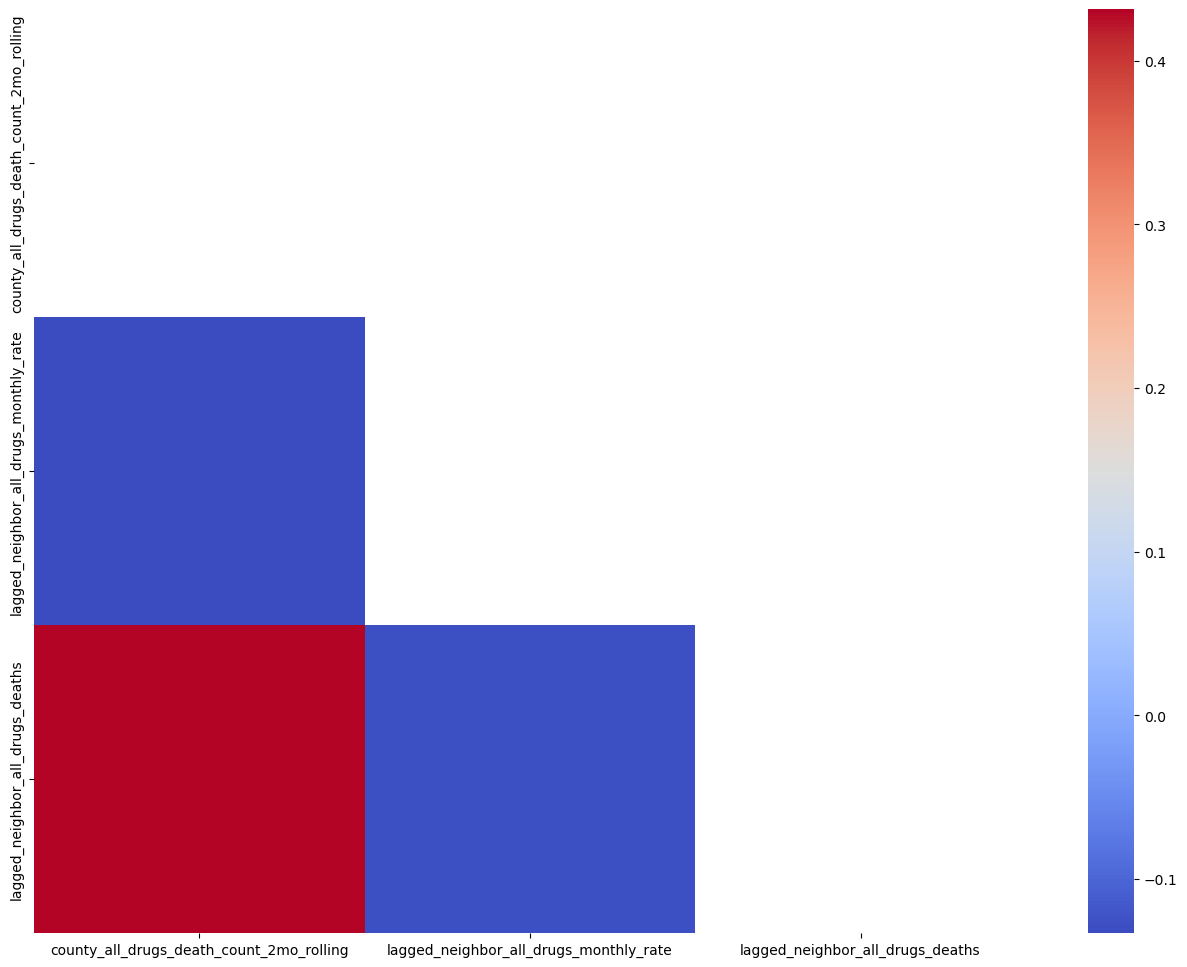

In [712]:
# inspect correlations for remaining features with missing data 
# filter df to null features 
df_null = df[null_feat_list]
# calculate correlation matrix
corr_matrix = df_null.corr()
# set repeated values in upper triangle of correlation matrix to NaN (simplify plot)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix[mask] = np.nan
# plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()
#lh_fx.make_feature_list_corr_heatmap(df, null_feat_list, "Heatmap of Feature Correlations (Pearson's R)")


In [713]:
# drop "3mo" features due to extremely high correlations with 2 month versions 
three_month_feats = [f for f in null_feat_list if "3mo" in f]
df.drop(three_month_feats, axis=1, inplace=True)
df.shape

(5568, 117)

In [714]:
null_feat_list = [f for f in null_feat_list if f not in three_month_feats]
null_feat_list

['county_all_drugs_death_count_2mo_rolling',
 'lagged_neighbor_all_drugs_monthly_rate',
 'lagged_neighbor_all_drugs_deaths']

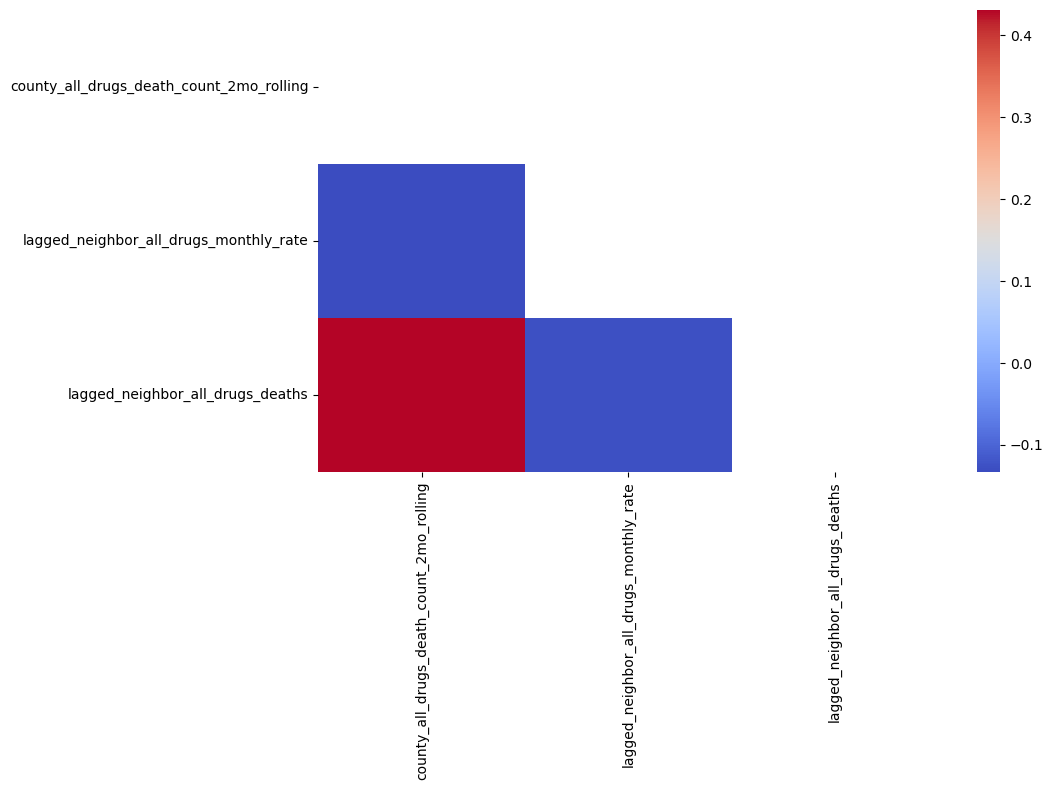

In [715]:
# filter df to null features 
df_null = df[null_feat_list]
# calculate correlation matrix
corr_matrix = df_null.corr()
# set repeated values in upper triangle of correlation matrix to NaN (simplify plot)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix[mask] = np.nan
# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

-  Retain 'lagged_neighbor_all_drugs_deaths' and drop: 
    - 'lagged_neighbor_all_drugs_deaths_2mo_rolling'
    - 'lagged_neighbor_all_drugs_avg_2mo'
    - 'lagged_neighbor_all_drugs_high_2mo'
    - 'lagged_neighbor_all_drugs_low_2mo'
- Retain 'county_all_drugs_death_count_2mo_rolling' and drop: 
    - 'county_all_drugs_death_avg_6mo'
    - 'county_all_drugs_death_high_2mo'
    - 'county_all_drugs_death_low_2mo'
    - 'county_all_drugs_death_avg_2mo'
- Retain 'lagged_neighbor_all_drugs_monthly_rate' (no additional highly correlated features) 

In [716]:
# hicorr_lag_feats = ['lagged_neighbor_all_drugs_deaths_2mo_rolling',
#                     'lagged_neighbor_all_drugs_avg_2mo',
#                     'lagged_neighbor_all_drugs_high_2mo',
#                     'lagged_neighbor_all_drugs_low_2mo',
#                     'county_all_drugs_death_avg_6mo',
#                     'county_all_drugs_death_high_2mo',
#                     'county_all_drugs_death_low_2mo',
#                     'county_all_drugs_death_avg_2mo']
# df.drop(hicorr_lag_feats, axis=1, inplace=True)
# df.shape

In [717]:
# write xlsx file for reviewing missing data with team
# non0_null_df = null_df[null_df['percent_null']>0]
# non0_null_df.to_excel("output/features_with_nulls_031024", engine='xlsxwriter')

### 5. Inspect multicollinearity and drop redundant features

In [718]:
# OLD DF VERSION: 

# calculate correlation matrix
# df_num = df.select_dtypes(include='number')
# corr_matrix = df_num.corr()
# # set repeated values in upper triangle of correlation matrix to NaN (simplify plot)
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# corr_matrix[mask] = np.nan
# # plot heatmap
# plt.figure(figsize=(16, 12))
# sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", mask=mask)
# plt.show()

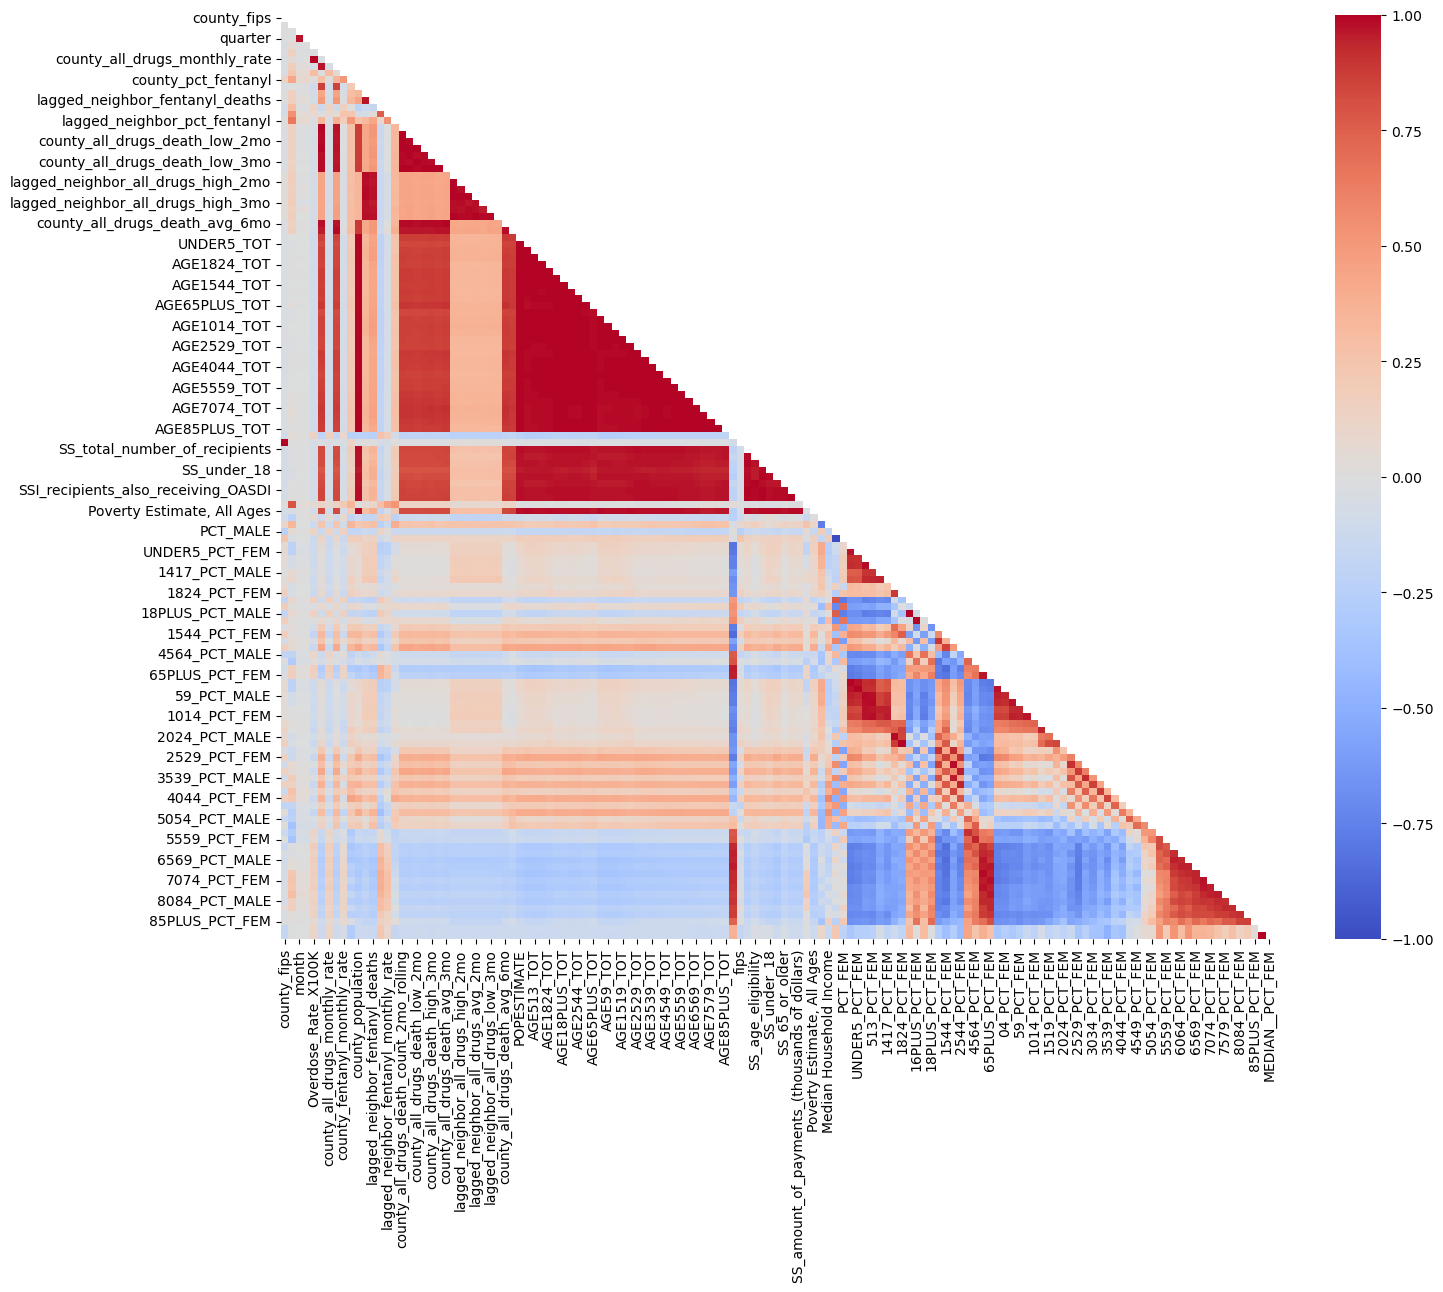

In [719]:
# DF_NEW VERSION: 

# calculate correlation matrix
df_num = df_new.select_dtypes(include='number')
corr_matrix = df_num.corr()
# set repeated values in upper triangle of correlation matrix to NaN (simplify plot)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix[mask] = np.nan
# plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()


### 6.  County population demographic features:
NOTE: already done in "df_new" ("raw_data/full_with_age_pcts_LSTM.csv")
1. Transform into non-overlapping percentages
2. Drop lower-granularity versions of features if redundant to higher-granularity versions

In [720]:
df.columns[15:107]

Index(['POPESTIMATE', 'POPEST_MALE', 'POPEST_FEM', 'UNDER5_TOT', 'UNDER5_MALE',
       'UNDER5_FEM', 'AGE513_TOT', 'AGE513_MALE', 'AGE513_FEM', 'AGE1417_TOT',
       'AGE1417_MALE', 'AGE1417_FEM', 'AGE1824_TOT', 'AGE1824_MALE',
       'AGE1824_FEM', 'AGE16PLUS_TOT', 'AGE16PLUS_MALE', 'AGE16PLUS_FEM',
       'AGE18PLUS_TOT', 'AGE18PLUS_MALE', 'AGE18PLUS_FEM', 'AGE1544_TOT',
       'AGE1544_MALE', 'AGE1544_FEM', 'AGE2544_TOT', 'AGE2544_MALE',
       'AGE2544_FEM', 'AGE4564_TOT', 'AGE4564_MALE', 'AGE4564_FEM',
       'AGE65PLUS_TOT', 'AGE65PLUS_MALE', 'AGE65PLUS_FEM', 'AGE04_TOT',
       'AGE04_MALE', 'AGE04_FEM', 'AGE59_TOT', 'AGE59_MALE', 'AGE59_FEM',
       'AGE1014_TOT', 'AGE1014_MALE', 'AGE1014_FEM', 'AGE1519_TOT',
       'AGE1519_MALE', 'AGE1519_FEM', 'AGE2024_TOT', 'AGE2024_MALE',
       'AGE2024_FEM', 'AGE2529_TOT', 'AGE2529_MALE', 'AGE2529_FEM',
       'AGE3034_TOT', 'AGE3034_MALE', 'AGE3034_FEM', 'AGE3539_TOT',
       'AGE3539_MALE', 'AGE3539_FEM', 'AGE4044_TOT', 'AGE4044_MALE',

### 7. Temporarily subset key columns in df for first round of modeling 

In [721]:
# messy - fix when time
model_cols = ['county_name',
              'period','year','month',
              'lagged_neighbor_all_drugs_deaths',
              'lagged_neighbor_all_drugs_monthly_rate',
              #'county_all_drugs_death_count_2mo_rolling', # - v. high corr
              'POPESTIMATE',
              'SS_total_number_of_recipients',# - v. high corr
              #'SS_age_eligibility', 'SS_blind_and_disabled_eligibility',
              # 'SS_under_18', 'SS_18_to_64', 'SS_65_or_older',
              # 'SSI_recipients_also_receiving_OASDI',
              # 'SS_amount_of_payments_(thousands of dollars)',
              'Fentanyl Seizures lbs',
              'Poverty Estimate, All Ages',
              'Poverty Percent, All Ages',
              'Median Household Income',
              'county_all_drugs_monthly_rate',]
# model_df = df[model_cols]
model_df_new = df_new[model_cols]

In [722]:
model_df_new.columns

Index(['county_name', 'period', 'year', 'month',
       'lagged_neighbor_all_drugs_deaths',
       'lagged_neighbor_all_drugs_monthly_rate', 'POPESTIMATE',
       'SS_total_number_of_recipients', 'Fentanyl Seizures lbs',
       'Poverty Estimate, All Ages', 'Poverty Percent, All Ages',
       'Median Household Income', 'county_all_drugs_monthly_rate'],
      dtype='object')

In [724]:
# select male population demographics cols only (fem. counterparts redundant)
md_cols = model_df_new.columns.to_list() 
male_pct_cols = [col for col in df_new.columns if "PCT_MALE" in col] 
male_pct_cols = male_pct_cols[1:-1]
md_cols.extend(male_pct_cols)
model_df_new = df_new[md_cols]
model_df_new.columns

Index(['county_name', 'period', 'year', 'month',
       'lagged_neighbor_all_drugs_deaths',
       'lagged_neighbor_all_drugs_monthly_rate', 'POPESTIMATE',
       'SS_total_number_of_recipients', 'Fentanyl Seizures lbs',
       'Poverty Estimate, All Ages', 'Poverty Percent, All Ages',
       'Median Household Income', 'county_all_drugs_monthly_rate',
       'UNDER5_PCT_MALE', '513_PCT_MALE', '1417_PCT_MALE', '1824_PCT_MALE',
       '16PLUS_PCT_MALE', '18PLUS_PCT_MALE', '1544_PCT_MALE', '2544_PCT_MALE',
       '4564_PCT_MALE', '65PLUS_PCT_MALE', '04_PCT_MALE', '59_PCT_MALE',
       '1014_PCT_MALE', '1519_PCT_MALE', '2024_PCT_MALE', '2529_PCT_MALE',
       '3034_PCT_MALE', '3539_PCT_MALE', '4044_PCT_MALE', '4549_PCT_MALE',
       '5054_PCT_MALE', '5559_PCT_MALE', '6064_PCT_MALE', '6569_PCT_MALE',
       '7074_PCT_MALE', '7579_PCT_MALE', '8084_PCT_MALE', '85PLUS_PCT_MALE'],
      dtype='object')

/var/folders/yl/yj1hlnzd3v7dx2jll1zhy2_m0000gn/T/ipykernel_99699/3988692226.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = model_df_new.corr()


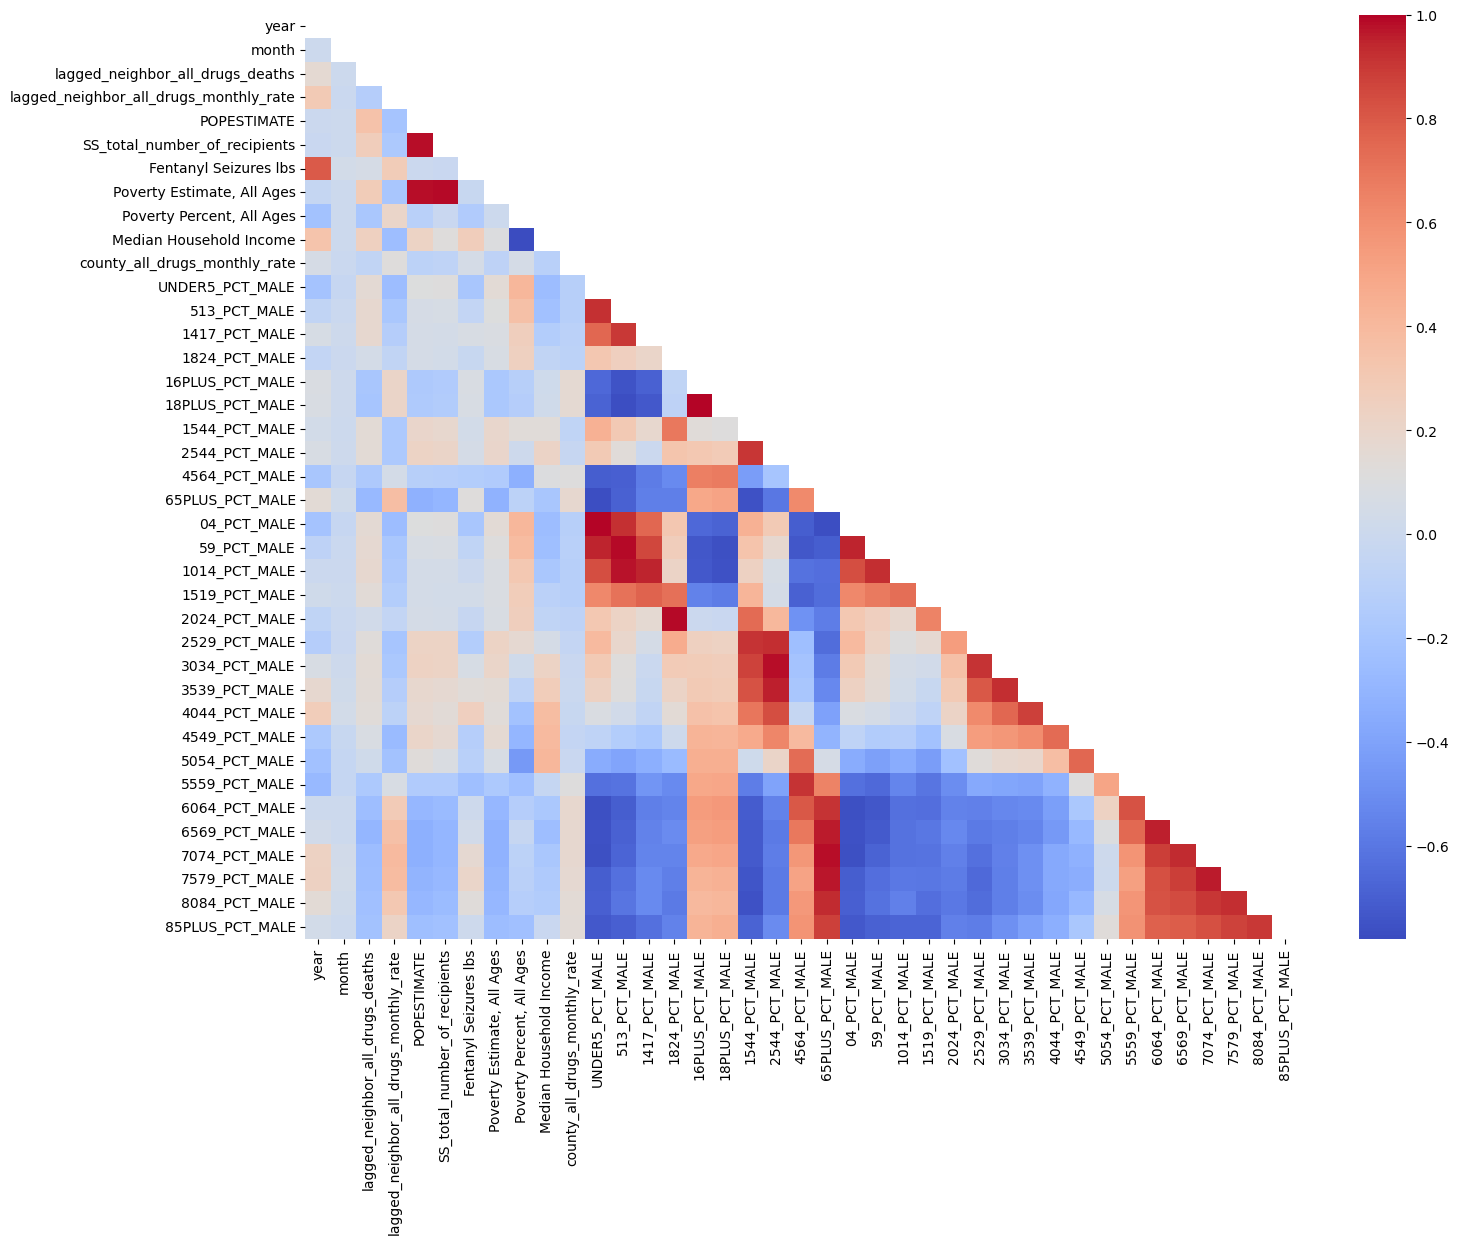

In [725]:
# re-check correlations 
corr_matrix = model_df_new.corr()
# set repeated values in upper triangle of correlation matrix to NaN (simplify plot)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix[mask] = np.nan
# plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", mask=mask)
plt.show()

### TO DO: drop more highly-correlated age group features?

### 8. Import & format county latitude/longitude coordinates to use as entity embeddings (county IDs)

In [726]:
# import lat/lon data to use as entity embedding for count id 
#SOURCE: https://public.opendatasoft.com/explore/dataset/us-county-boundaries/export/?flg=en-us&disjunctive.statefp&disjunctive.countyfp&disjunctive.name&disjunctive.namelsad&disjunctive.stusab&disjunctive.state_name&sort=stusab&refine.stusab=CA
county_ll = pd.read_csv('raw_data/ca-county-boundaries_latlon.csv',sep=";")
county_ll.head()

,Geo Point,Geo Shape,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,STUSAB,LSAD,...,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,STATE_NAME,COUNTYFP NOZERO
0,"36.0753604529, -119.815502709","{""coordinates"": [[[-119.958925, 36.255468], [-...",6,31,277280,6031,Kings,Kings County,CA,6,...,260.0,25260.0,NaN,A,3600883803,3162664,36.072478,-119.815530,California,31
1,"36.6057058971, -121.074995529","{""coordinates"": [[[-121.483002, 36.76505], [-1...",6,69,277299,6069,San Benito,San Benito County,CA,6,...,488.0,41940.0,NaN,A,3596591082,4719300,36.611651,-121.085811,California,69
2,"36.7581801263, -119.649322632","{""coordinates"": [[[-120.422187, 36.840139], [-...",6,19,277274,6019,Fresno,Fresno County,CA,6,...,260.0,23420.0,NaN,A,15432139300,136609898,36.761006,-119.655019,California,19
3,"40.0046824769, -120.838597596","{""coordinates"": [[[-121.367008, 40.077673], [-...",6,63,277296,6063,Plumas,Plumas County,CA,6,...,NaN,NaN,NaN,A,6612400910,156387636,39.992295,-120.824371,California,63
4,"36.5111268089, -117.410789686","{""coordinates"": [[[-118.337579, 36.654801], [-...",6,27,1804637,6027,Inyo,Inyo County,CA,6,...,NaN,NaN,NaN,A,26410680788,76915743,36.561977,-117.403927,California,27


In [727]:
# separate lat and long columns in county df 
county_ll[['county_lat_pt', 'county_lon_pt']] = county_ll['Geo Point'].str.split(', ', n=1, expand=True)
# convert both to numeric
county_ll[['county_lat_pt', 'county_lon_pt']] = county_ll[['county_lat_pt','county_lon_pt']].apply(pd.to_numeric)
county_ll.dtypes

Geo Point           object
Geo Shape           object
STATEFP              int64
COUNTYFP             int64
COUNTYNS             int64
GEOID                int64
NAME                object
NAMELSAD            object
STUSAB              object
LSAD                 int64
CLASSFP             object
MTFCC               object
CSAFP              float64
CBSAFP             float64
METDIVFP           float64
FUNCSTAT            object
ALAND                int64
AWATER               int64
INTPTLAT           float64
INTPTLON           float64
STATE_NAME          object
COUNTYFP NOZERO      int64
county_lat_pt      float64
county_lon_pt      float64
dtype: object

In [728]:
county_ll = county_ll[['NAME','county_lat_pt','county_lon_pt']]

In [729]:
model_df_new.county_name

0       ALAMEDA
1       ALAMEDA
2       ALAMEDA
3       ALAMEDA
4       ALAMEDA
         ...   
5563       YUBA
5564       YUBA
5565       YUBA
5566       YUBA
5567       YUBA
Name: county_name, Length: 5568, dtype: object

In [730]:
# # merge lat/lon data with model df 
# model_df['county_name'] = model_df['county_name'].str.title()
# model_df = model_df.merge(county_ll, left_on='county_name', right_on='NAME')
# model_df.head()

In [731]:
#model_df_new['county_name'] = model_df_new['county_name'].str.title()
model_df_new['county_name'] = model_df_new['county_name'].str.title()
model_df_new = model_df_new.merge(county_ll, left_on='county_name', right_on='NAME')
model_df_new.head()

/var/folders/yl/yj1hlnzd3v7dx2jll1zhy2_m0000gn/T/ipykernel_99699/1125126351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df_new['county_name'] = model_df_new['county_name'].str.title()


,county_name,period,year,month,lagged_neighbor_all_drugs_deaths,lagged_neighbor_all_drugs_monthly_rate,POPESTIMATE,SS_total_number_of_recipients,Fentanyl Seizures lbs,"Poverty Estimate, All Ages",...,5559_PCT_MALE,6064_PCT_MALE,6569_PCT_MALE,7074_PCT_MALE,7579_PCT_MALE,8084_PCT_MALE,85PLUS_PCT_MALE,NAME,county_lat_pt,county_lon_pt
0,Alameda,2016-01-01,2016,1,NaN,NaN,1650765,50959,175.43,184716,...,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,Alameda,37.650493,-121.917999
1,Alameda,2016-02-01,2016,2,47.0,0.787565,1650765,50959,175.43,184716,...,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,Alameda,37.650493,-121.917999
2,Alameda,2016-03-01,2016,3,54.0,0.904862,1650765,50959,175.43,184716,...,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,Alameda,37.650493,-121.917999
3,Alameda,2016-04-01,2016,4,57.0,0.955132,1650765,50959,175.43,184716,...,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,Alameda,37.650493,-121.917999
4,Alameda,2016-05-01,2016,5,47.0,0.787565,1650765,50959,175.43,184716,...,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,Alameda,37.650493,-121.917999


In [732]:
model_df_new.drop('NAME', axis=1,inplace=True)

### TO DO: transform lat/long coordinate features appropriately (sin-cosin + vector?) 

### 9. Recheck nulls 

In [733]:
# model_null_df = lh_fx.make_null_df(model_df)
# model_null_df[model_null_df['percent_null']>0]

model_null_df = lh_fx.make_null_df(model_df_new)
model_null_df[model_null_df['percent_null']>0]

,feature_name,percent_null
0,lagged_neighbor_all_drugs_deaths,1.041667
1,lagged_neighbor_all_drugs_monthly_rate,1.041667


In [735]:
last_nulls = model_null_df[model_null_df['percent_null']>0].feature_name.to_list()
lh_fx.null_values_percentage_by_county_and_period(model_df_new, last_nulls)

{'lagged_neighbor_all_drugs_deaths':         county_name     period  null_percentage
 0           Alameda 2016-01-01            100.0
 1            Alpine 2016-01-01            100.0
 2            Amador 2016-01-01            100.0
 3             Butte 2016-01-01            100.0
 4         Calaveras 2016-01-01            100.0
 5            Colusa 2016-01-01            100.0
 6      Contra Costa 2016-01-01            100.0
 7         Del Norte 2016-01-01            100.0
 8         El Dorado 2016-01-01            100.0
 9            Fresno 2016-01-01            100.0
 10            Glenn 2016-01-01            100.0
 11         Humboldt 2016-01-01            100.0
 12         Imperial 2016-01-01            100.0
 13             Inyo 2016-01-01            100.0
 14             Kern 2016-01-01            100.0
 15            Kings 2016-01-01            100.0
 16             Lake 2016-01-01            100.0
 17           Lassen 2016-01-01            100.0
 18      Los Angeles 2016-01-01  

In [737]:
# drop rows for period = 1/2016 (source of all remaining nulls due to lag feature calcs)
model_df_new= model_df_new[model_df_new['period']!='2016-01-01']

In [739]:
model_null_df = lh_fx.make_null_df(model_df_new)
model_null_df[model_null_df['percent_null']>0]

,feature_name,percent_null


In [740]:
model_df_new.head()

,county_name,period,year,month,lagged_neighbor_all_drugs_deaths,lagged_neighbor_all_drugs_monthly_rate,POPESTIMATE,SS_total_number_of_recipients,Fentanyl Seizures lbs,"Poverty Estimate, All Ages",...,5054_PCT_MALE,5559_PCT_MALE,6064_PCT_MALE,6569_PCT_MALE,7074_PCT_MALE,7579_PCT_MALE,8084_PCT_MALE,85PLUS_PCT_MALE,county_lat_pt,county_lon_pt
1,Alameda,2016-02-01,2016,2,47.0,0.787565,1650765,50959,175.43,184716,...,3.324822,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,37.650493,-121.917999
2,Alameda,2016-03-01,2016,3,54.0,0.904862,1650765,50959,175.43,184716,...,3.324822,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,37.650493,-121.917999
3,Alameda,2016-04-01,2016,4,57.0,0.955132,1650765,50959,175.43,184716,...,3.324822,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,37.650493,-121.917999
4,Alameda,2016-05-01,2016,5,47.0,0.787565,1650765,50959,175.43,184716,...,3.324822,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,37.650493,-121.917999
5,Alameda,2016-06-01,2016,6,65.0,1.089185,1650765,50959,175.43,184716,...,3.324822,3.171499,2.702686,2.149912,1.405833,0.925631,0.625831,0.624256,37.650493,-121.917999


In [551]:
# model_df.reset_index(drop=True, inplace=True)
# model_df.drop('NAME', axis=1,inplace=True)

In [552]:
# # sort in ascending date order and reindex
# model_df.sort_values(by='period',inplace=True)
# model_df.reset_index(drop=True, inplace=True)

In [553]:
# model_df.head()

,county_name,period,year,month,lagged_neighbor_all_drugs_deaths,lagged_neighbor_all_drugs_monthly_rate,POPESTIMATE,SS_total_number_of_recipients,Fentanyl Seizures lbs,"Poverty Estimate, All Ages","Poverty Percent, All Ages",Median Household Income,county_all_drugs_monthly_rate,county_lat_pt,county_lon_pt
0,Alameda,2016-02-01,2016,2,47.0,0.787565,1650765,50959,175.43,184716,11.5,81462,0.796945,37.650493,-121.917999
1,Contra Costa,2016-02-01,2016,2,61.0,1.029019,1137259,26195,175.43,114123,10.2,83036,1.241538,37.923379,-121.951073
2,Monterey,2016-02-01,2016,2,28.0,1.605248,433436,8682,175.43,63732,15.3,60047,0.000000,36.239774,-121.308902
3,San Bernardino,2016-02-01,2016,2,177.0,1.069200,2130726,72570,175.43,394031,18.9,53526,0.235562,34.841438,-116.178461
4,Yolo,2016-02-01,2016,2,36.0,1.599646,215569,5474,175.43,35877,17.5,58766,2.326837,38.686660,-121.901617


## Train test split

In [554]:
# train test split ratio: 70%/30% 
# set index to 'period'
model_df.set_index('period', inplace=True)
# sort by period 
model_df.sort_index(inplace=True)
# remove labels from X features
# X = model_df.drop(labels=['county_all_drugs_monthly_rate'], axis=1)
# # create vector of target data 
# y = model_df['county_all_drugs_monthly_rate']

In [501]:
# train test split ratio: 70%/30% 
# set index to 'period'
# model_df_new.set_index('period', inplace=True)
# # sort by period 
# model_df_new.sort_index(inplace=True)

# model_df_new.head()
# # remove labels from X features
# X = model_df.drop(labels=['county_all_drugs_monthly_rate'], axis=1)
# # create vector of target data 
# y = model_df['county_all_drugs_monthly_rate']

# model_df_new.set_index('period', inplace=True)
# # sort by period 
# model_df_new.sort_index(inplace=True)


In [555]:
# instntiate time series split
tss_tt = TimeSeriesSplit(
    n_splits=2,
    gap=0,
    max_train_size=3856,
    test_size=1653,
)
for i, (train_index, test_index) in enumerate(tss_tt.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
# split train test sets for both features and targets
for train_index, test_index in tss_tt.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Fold 0:
  Train: index=[   0    1    2 ... 2201 2202 2203]
  Test:  index=[2204 2205 2206 ... 3854 3855 3856]
Fold 1:
  Train: index=[   1    2    3 ... 3854 3855 3856]
  Test:  index=[3857 3858 3859 ... 5507 5508 5509]


In [556]:
lstm_train = model_df_new.loc[(model_df_new['period'] <= '2020-09-01')]# & (df['date'] < '2020-09-15')]

In [ ]:
# instntiate time series split
tss_tv = TimeSeriesSplit(
    n_splits=2,
    gap=0,
    max_train_size=2899,
    test_size=956,
)
for i, (train_index, test_index) in enumerate(tss_tv.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Val:  index={test_index}")
# split train test sets for both features and targets
# for train_index, test_index in tss_tv.split(X):
#     X_train, X_val = X_train.iloc[train_index, :], X_train.iloc[test_index,:]
#     y_train, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

In [557]:
# model_df_new.reset_index(inplace=True)
# model_df_new['period'] = pd.to_datetime(model_df_new['period'],format = '%Y%m')
lstm_train = model_df_new.loc[(model_df_new['period'] <= '2020-11-01')]#& (df['date'] < '2020-09-15')]
lstm_train.shape[0]/model_df_new.shape[0]

0.6105263157894737

In [558]:
lstm_val = model_df_new.loc[(model_df_new['period']>'2020-11-01') & (model_df_new['period']<='2022-05-01')]
lstm_val.shape[0]/model_df_new.shape[0]

0.18947368421052632

In [559]:
# lstm_train.to_csv("split_data/lstm_train.csv")
# lstm_val.to_csv("split_data/lstm_val.csv")
# lstm_test.to_csv("split_data/lstm_test.csv")

In [ ]:
lstm_val.columns

## Data Transformations 

source: https://machinelearningmastery.com/use-timesteps-lstm-networks-time-series-forecasting/

The following three data transforms are performed on the dataset prior to fitting a model and making a forecast.
- Transform the time series data so that it is stationary. Specifically, a lag=1 differencing to remove the increasing trend in the data.
- Transform the time series into a supervised learning problem. Specifically, the organization of data into input and output patterns where the observation at the previous time step is used as an input to forecast the observation at the current time timestep
- Transform the observations to have a specific scale. Specifically, to rescale the data to values between -1 and 1 to meet the default hyperbolic tangent activation function of the LSTM model.


### 1. One hot encoding of 'county_name'

In [ ]:
# # define function to OHE selected columns
# def OHE_vars(train, test, val=None, target):
#     '''
#     arguments: train and test dfs (and optional validation set df) and the target feature to encode.
#     fits OHE encoder to the train and transforms both. 
#     returns entire datasets in tuple format with target feature transformed.
#     '''
#     # check if column_name exists in the DataFrame
#     if target not in train.columns:
#         raise ValueError(f"Column '{target}' does not exist in the DataFrame.")
#     #creating encoder
#     temp_encoder = ce.OneHotEncoder(cols=[target],use_cat_names=True)
#     # fit the encoder to train
#     temp_encoder.fit(train)
#     # transform both datasets with encoder
#     train = temp_encoder.transform(train)
    
#     test = temp_encoder.transform(test)
    
#     return train, test

# # apply function
# X_train, X_test = OHE_vars(X_train, X_test, val=X_val, 'county_name')

In [ ]:
#lstm_temp = lstm_train.copy() 
# lstm_train_temp = lstm_train.copy() 
# lstm_test_temp = lstm_test.copy() 
temp_encoder = ce.OneHotEncoder(cols=['county_name'],use_cat_names=True)
# fit the encoder to train
temp_encoder.fit(lstm_train)
    # transform both datasets with encoder
lstm_train = temp_encoder.transform(lstm_train)
lstm_val = temp_encoder.transform(lstm_val)
lstm_test = temp_encoder.transform(lstm_test)
lstm_train.head()

In [565]:

# lstm_train.set_index('period', inplace=True)
# sort by period 
lstm_train.sort_index(inplace=True)

# lstm_val.set_index('period', inplace=True)
lstm_val.sort_index(inplace=True)

# lstm_test.set_index('period', inplace=True)
lstm_test.sort_index(inplace=True)

# lstm_train.drop(['level_0 	level_0 	ind = temp_encoder.transform(lstm_train)
# lstm_val = temp_encoder.transform(lstm_val)
# lstm_test = 

In [566]:
#lstm_train.drop(['level_0', 'index'], axis=1, inplace=True)
#lstm_val.drop(['level_0', 'index'], axis=1, inplace=True)
# lstm_val.head()
# lstm_test.drop(['level_0', 'index'], axis=1, inplace=True)
# lstm_test
# lstm_train
# lstm_val = lstm_val.iloc[:,2:]
# lstm_test = lstm_test.iloc[:,2:]

,county_name_Alameda,county_name_Alpine,county_name_Amador,county_name_Butte,county_name_Calaveras,county_name_Colusa,county_name_Contra Costa,county_name_Del Norte,county_name_El Dorado,county_name_Fresno,...,5054_PCT_MALE,5559_PCT_MALE,6064_PCT_MALE,6569_PCT_MALE,7074_PCT_MALE,7579_PCT_MALE,8084_PCT_MALE,85PLUS_PCT_MALE,county_lat_pt,county_lon_pt
period,,,,,,,,,,,,,,,,,,,,,
2020-12-01,1,0,0,0,0,0,0,0,0,0,...,3.172548,3.092720,2.808780,2.251608,1.756277,1.104839,0.705459,0.684283,37.650493,-121.917999
2020-12-01,0,0,0,0,0,0,0,0,0,0,...,2.704725,2.641342,2.397118,1.867847,1.442783,0.967943,0.591222,0.514947,37.191870,-120.717688
2020-12-01,0,0,0,0,0,0,0,1,0,0,...,2.817506,3.339531,3.557637,3.210812,2.660183,1.462386,0.829519,0.800915,41.744942,-123.957801
2020-12-01,0,0,0,0,0,0,0,0,0,0,...,3.160147,3.327964,3.347563,3.162597,2.719984,1.701037,0.920340,0.876242,38.525293,-122.922545
2020-12-01,0,0,0,0,0,0,0,0,0,0,...,3.284022,3.283626,3.015266,2.484215,1.979143,1.288131,0.866798,0.896997,37.436210,-122.355663


### 2. Scale numeric data using RobustScaler to address skewed income features 
- source: https://www.mdpi.com/2077-1312/10/12/1931

### TO DO: plot before/after to see if this worked, or if we need logs transformations, etc. 

In [568]:
# display all features and dtypes
for c, d in zip(lstm_train.columns, df.dtypes):
    print(f"{c}: {d}")

county_name_Alameda: int64
county_name_Alpine: object
county_name_Amador: object
county_name_Butte: object
county_name_Calaveras: datetime64[ns]
county_name_Colusa: int64
county_name_Contra Costa: int64
county_name_Del Norte: int64
county_name_El Dorado: float64
county_name_Fresno: int64
county_name_Glenn: float64
county_name_Humboldt: int64
county_name_Imperial: float64
county_name_Inyo: float64
county_name_Kern: float64
county_name_Kings: int64
county_name_Lake: int64
county_name_Lassen: int64
county_name_Los Angeles: int64
county_name_Madera: int64
county_name_Marin: int64
county_name_Mariposa: int64
county_name_Mendocino: int64
county_name_Merced: int64
county_name_Modoc: int64
county_name_Mono: int64
county_name_Monterey: int64
county_name_Napa: int64
county_name_Nevada: int64
county_name_Orange: int64
county_name_Placer: int64
county_name_Plumas: int64
county_name_Riverside: int64
county_name_Sacramento: int64
county_name_San Benito: int64
county_name_San Bernardino: int64
county

In [569]:
for col in lstm_train.columns:
    if "county_name" in col:
        lstm_train[col] = lstm_train[col].astype(int)
lstm_train.dtypes

county_name_Alameda        int64
county_name_Alpine         int64
county_name_Amador         int64
county_name_Butte          int64
county_name_Calaveras      int64
                          ...   
7579_PCT_MALE            float64
8084_PCT_MALE            float64
85PLUS_PCT_MALE          float64
county_lat_pt            float64
county_lon_pt            float64
Length: 99, dtype: object

In [570]:
for col in lstm_val.columns:
    if "county_name" in col:
        lstm_val[col] = lstm_val[col].astype(int)
lstm_val.dtypes

county_name_Alameda        int64
county_name_Alpine         int64
county_name_Amador         int64
county_name_Butte          int64
county_name_Calaveras      int64
                          ...   
7579_PCT_MALE            float64
8084_PCT_MALE            float64
85PLUS_PCT_MALE          float64
county_lat_pt            float64
county_lon_pt            float64
Length: 99, dtype: object

In [571]:
# display all features and dtypes
for col in lstm_test.columns:
    if "county_name" in col:
        lstm_test[col] = lstm_test[col].astype(int)
lstm_test.dtypes

county_name_Alameda             int64
county_name_Contra Costa        int64
county_name_Monterey            int64
county_name_San Bernardino      int64
county_name_Yolo                int64
                               ...   
7579_PCT_MALE                 float64
8084_PCT_MALE                 float64
85PLUS_PCT_MALE               float64
county_lat_pt                 float64
county_lon_pt                 float64
Length: 99, dtype: object

In [429]:
# display all features and dtypes
for c, d in zip(lstm_train.columns, lstm_train.dtypes):
    print(f"{c}: {d}")

county_name_Alameda: int64
county_name_Contra Costa: int64
county_name_Monterey: int64
county_name_San Bernardino: int64
county_name_Yolo: int64
county_name_Sonoma: int64
county_name_Solano: int64
county_name_Mono: int64
county_name_Mariposa: int64
county_name_Kern: int64
county_name_Kings: int64
county_name_San Diego: int64
county_name_San Francisco: int64
county_name_Alpine: int64
county_name_Siskiyou: int64
county_name_Inyo: int64
county_name_San Joaquin: int64
county_name_El Dorado: int64
county_name_Yuba: int64
county_name_Sierra: int64
county_name_Imperial: int64
county_name_Del Norte: int64
county_name_San Luis Obispo: int64
county_name_Stanislaus: int64
county_name_Sacramento: int64
county_name_Nevada: int64
county_name_Madera: int64
county_name_Orange: int64
county_name_Tuolumne: int64
county_name_Tulare: int64
county_name_Los Angeles: int64
county_name_Trinity: int64
county_name_Placer: int64
county_name_Calaveras: int64
county_name_San Benito: int64
county_name_Lassen: int64

In [434]:
lstm_train.columns[60:]

'month'

In [ ]:
scale_feats = lstm_train.columns[60:].to_list()
# rscaler = RobustScaler().fit(lstm_train[scale_feats])
# lstm_train[scale_feats] = rscaler.transform(lstm_train[scale_feats])


In [ ]:
lstm_train[scale_feats] = rscaler.fit_transform(lstm_train[scale_feats])
# lstm_val[scale_feats] = rscaler.transform(lstm_val[scale_feats])
# lstm_test[scale_feats] = rscaler.transform(lstm_test[scale_feats])

In [572]:
# write files to "split_data" dir 
lstm_train.to_csv("split_data/lstm_train.csv")
lstm_val.to_csv("split_data/lstm_val.csv")
lstm_test.to_csv("split_data/lstm_test.csv")
# combined train + val set 
lstm_trainval = pd.concat([lstm_train,lstm_val], axis=0)
lstm_trainval.to_csv("split_data/lstm_trainval.csv")

In [ ]:
# from tensorflow import feature_column
# latitude = feature_column.numeric_column("latitude")
# longitude = feature_column.numeric_column("longitude")
# latitude = feature_column.bucketized_column(latitude, boundaries=[...])
# longitude = feature_column.bucketized_column(longitude, boundaries=[...])

## TO DO: experiment with county clustering methods (DBSCAN, et.) 

In [582]:
# Define features to scale
# features_to_scale = ['feature1', 'feature2', 'feature3']
rscale_feats = lstm_trainval.columns[58:].to_list()
# Initialize and fit RobustScaler
scaler = RobustScaler()
scaler.fit(lstm_trainval[rscale_feats])

# Transform and update the DataFrame
lstm_trainval[rscale_feats] = scaler.transform(lstm_trainval[rscale_feats])

In [583]:
lstm_trainval.to_csv("split_data/lstm_trainval.csv")

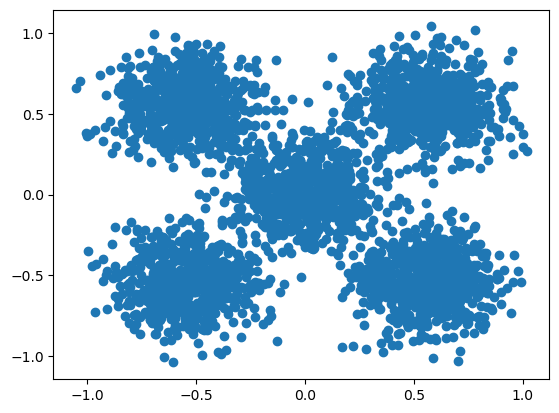

In [669]:
# from sklearn.datasets import make_blobs
# from sklearn.preprocessing import StandardScaler

lstm_train = pd.read_csv("split_data/lstm_train.csv")
lstm_train_y = lstm_train['county_all_drugs_monthly_rate']

lstm_train_X = lstm_train.drop('county_all_drugs_monthly_rate', axis=1)
lstm_train_X = lstm_train_X.drop('period', axis=1)

centers = [[-1, -1], [-1, 1], [0,0], [1, -1],[1,1]]
lstm_train_X, lstm_train_y = make_blobs(
    n_samples=len(lstm_train_X), centers=centers, cluster_std=0.3, random_state=0
)

lstm_train_X = RobustScaler().fit_transform(lstm_train_X)

plt.scatter(lstm_train_X[:, 0], lstm_train_X[:, 1])
plt.show()

In [ ]:
## db = DBSCAN(eps=0.3, min_samples=10).fit(lstm_train_X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

In [668]:
# get cluster ids (same dim as original X df) 
labels

array([0, 0, 0, ..., 0, 0, 0])

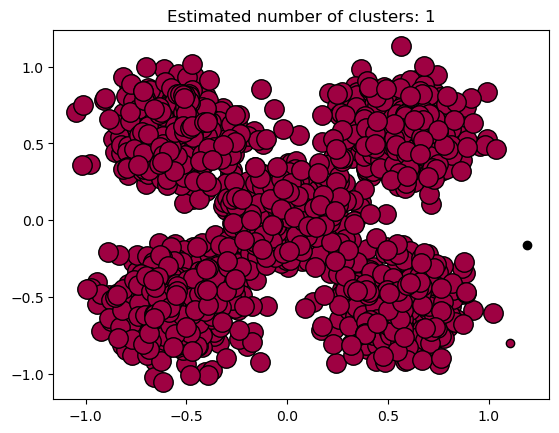

In [665]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = lstm_train_X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = lstm_train_X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()


In [646]:

# temp_encoder = ce.OneHotEncoder(cols=['county_name'],use_cat_names=True)
# # fit the encoder to train
# temp_encoder.fit(model_df_new)
#     # transform both datasets with encoder
# model_df_new = temp_encoder.transform(model_df_new)
# model_df_new.head()

# model_df_new_temp = model_df_new.drop('period', axis=1)
# model_df_new_temp_y= model_df_new['county_all_drugs_monthly_rate']
# model_df_new_temp_X = model_df_new.drop('county_all_drugs_monthly_rate', axis=1)



# centers = [[-1, -1], [-1, 1], [1, -1],[1,1]]
# lstm_train, labels_true = make_blobs(
#     n_samples=750, centers=centers, cluster_std=5, random_state=0
# )

# lstm_train_X = StandardScaler().fit_transform(model_df_new_temp_X)

# plt.scatter(lstm_train_X[:, 0], lstm_train_X[:, 1])
# plt.show()
